# Introduction
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become cancer, with melanoma being the deadliest skin cancer. Its incidence has increased during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for skin cancer detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

## Goal of the challenge
The goal of this challenge is to classify dermoscopic images of skin lesions among eight different diagnostic classes:
1. Melanoma
2. Melanocytic nevus
3. Basal cell carcinoma
4. Actinic keratosis
5. Benign keratosis
6. Dermatofibroma
7. Vascular lesion
8. Squamous cell carcinoma
In order to do that, you will extract features such as the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (usually called the ABCD rule). After that, you will use machine learning algorithms to classify the images.

# Libraries

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from skimage.io import imread
from skimage.segmentation import chan_vese
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [6]:
train_directory = './Train/Train'
test_directory = './Test/Test'

# Data
You will use a data-set of 25331 dermoscopic images of skin lesions with, when available, their relative segmentation and metadata (age, sex and anatomical position). Data has already been randomly split into a training-validation set (75%) and a test set (25%). You only have the classification (made by clinicians) of the training-validation set. The goal of the project is to estimate the correct class of each dermoscopic image in the test set. **You can only use the data provided in this challenge**



### Data Load

In [7]:
# Load the data
train_data = pd.read_csv('metadataTrain.csv')
test_data = pd.read_csv('metadataTest.csv')


In [8]:
# Load the images
train_images_filenames = os.listdir(train_directory)
test_images_filenames = os.listdir(test_directory)

train_images = []
train_masks = []
test_images = []
test_masks = []

#Give me the code to put the images in the lists, the masks in the other lists, the mask are the images that finish with _seg.png
for image in train_images_filenames:
    if image.endswith('_seg.png'):
        #Save the name whitout the _seg.png and the image
        train_masks.append([image[:-8], imread(train_directory + '/' + image)])
    else:
        #Save the name without the .png and the image
        train_images.append([image[:-4], imread(train_directory + '/' + image)])
        
for image in test_images_filenames:
    if image.endswith('_seg.png'):
        #Save the name whitout the _seg.png and the image
        test_masks.append([image[:-8], imread(test_directory + '/' + image)])
    else:
        #Save the name without the .png and the image
        test_images.append([image[:-4], imread(test_directory + '/' + image)])



## Data Analysis

### Text Features

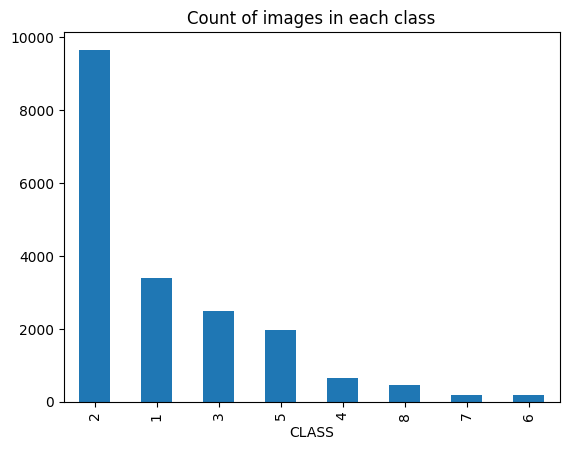

In [9]:
# Value counts of the classes
train_data['CLASS'].value_counts().plot(kind='bar')
plt.title('Count of images in each class')
plt.show()

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        18998 non-null  object 
 1   CLASS     18998 non-null  int64  
 2   SEX       18714 non-null  object 
 3   AGE       18674 non-null  float64
 4   POSITION  17028 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 742.2+ KB


In [11]:
# Description of the data 
train_data.describe(include='object')

,ID,SEX,POSITION
count,18998,18714,17028
unique,18998,2,8
top,ISIC_0028766,male,anterior torso
freq,1,9978,5194


In [12]:
train_data.describe()

,CLASS,AGE
count,18998.000000,18674.000000
mean,2.568323,53.991914
std,1.532728,18.094209
min,1.000000,0.000000
25%,2.000000,40.000000
50%,2.000000,55.000000
75%,3.000000,70.000000
max,8.000000,85.000000


In [13]:
test_data.describe(include='object')

,ID,SEX,POSITION
count,6333,6233,5672
unique,6333,2,8
top,ISIC_0055289,male,anterior torso
freq,1,3308,1721


In [14]:
test_data.describe()

,AGE
count,6220.000000
mean,54.138264
std,18.241916
min,0.000000
25%,40.000000
50%,55.000000
75%,70.000000
max,85.000000


### Image Features

In [15]:
#Count images loaded
print(f'Number of training images: {len(train_images)}')
print(f'Number of training masks: {len(train_masks)}')

print(f'Number of testing images: {len(test_images)}')
print(f'Number of testing masks: {len(test_masks)}')
    

Number of training images: 18998
Number of training masks: 1945
Number of testing images: 6333
Number of testing masks: 648


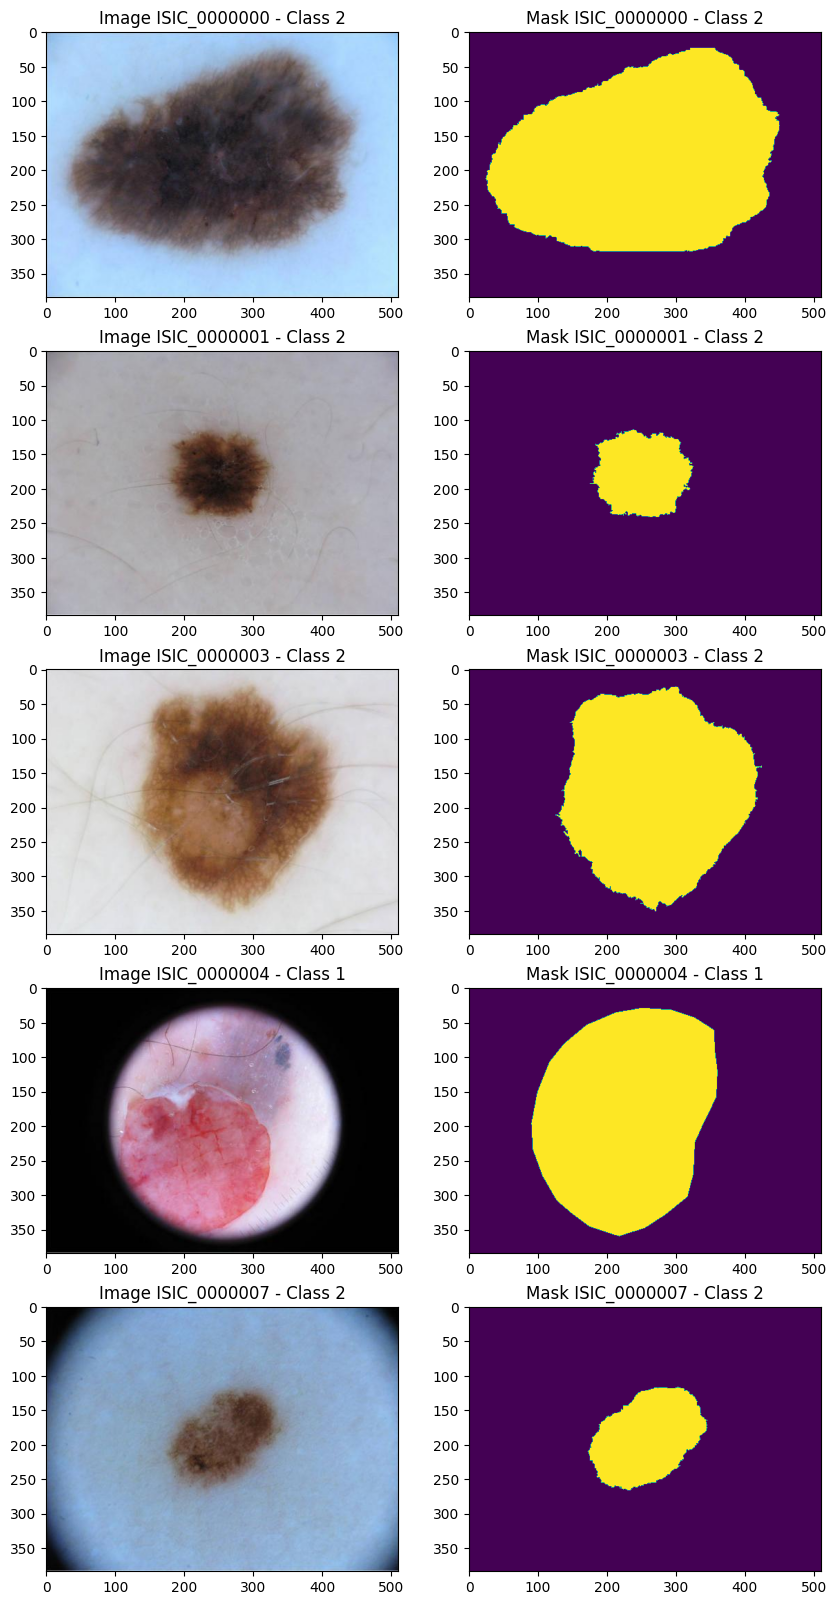

In [16]:
# Display a few images with the corresponding masks the corresponding masks have the same id as the image and their class

# Display the first 5 images
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

#get the first 5 masks
first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0
for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    #Get the mask
    mask = next((item for item in train_masks if item[0] == i), None)
    
    #Get the class
    class_ = train_data[train_data['ID'] == i]['CLASS'].values[0]
    
    #Plot the image
    ax[j, 0].imshow(image[1])
    ax[j, 0].set_title(f'Image { image[0] } - Class {class_}')
    
    #Plot the mask
    ax[j, 1].imshow(mask[1])
    ax[j, 1].set_title(f'Mask {mask[0]} - Class {class_}')

    j += 1


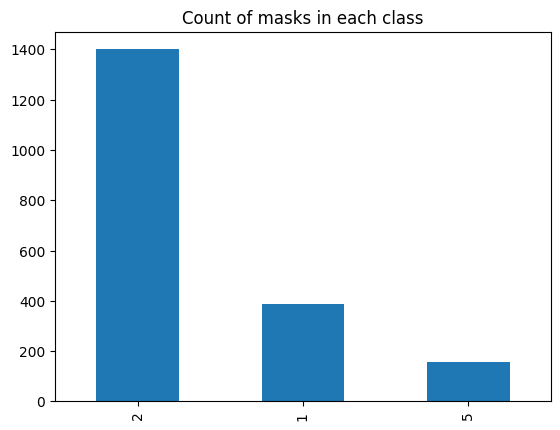

In [17]:
# Value counts of the classes in the masks

#Get the classes of the masks
masks_classes = [train_data[train_data['ID'] == mask[0]]['CLASS'].values[0] for mask in train_masks]

#Plot the classes
pd.Series(masks_classes).value_counts().plot(kind='bar')
plt.title('Count of masks in each class')
plt.show()


# Image Processing
You can use all features you'd like. A list of references describing very well-known features can be found at the end of this page but you can find many more articles in the Literature. You can use Pubmed, Google Scholar or simply Google to look for them.


## Image Preprocessing

In [18]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#Convert the image from RGB to grayscale.
train_images= [[image[0], image[1], get_grayscale(image[1])] for image in train_images]
test_images= [[image[0], image[1], get_grayscale(image[1])] for image in test_images]

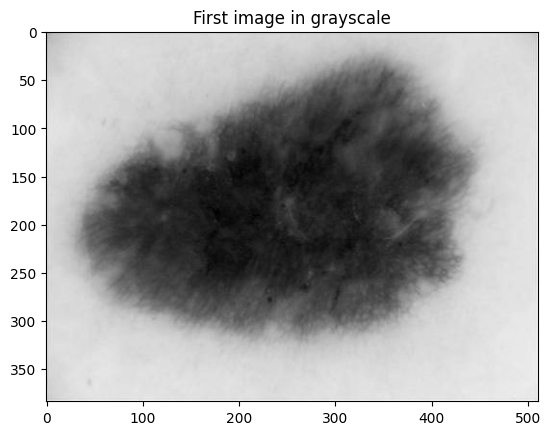

In [19]:
# Display the first image
plt.imshow(train_images[0][2], cmap='gray')
plt.title('First image in grayscale')
plt.show()

In [20]:
def get_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

#Apply an anisotropic diffusion filter to the grayscale image for smoothing.
train_images = [[image[0], image[1], image[2],get_gaussian_blur(image[2])] for image in train_images]
test_images = [[image[0], image[1], image[2],get_gaussian_blur(image[2])] for image in test_images]

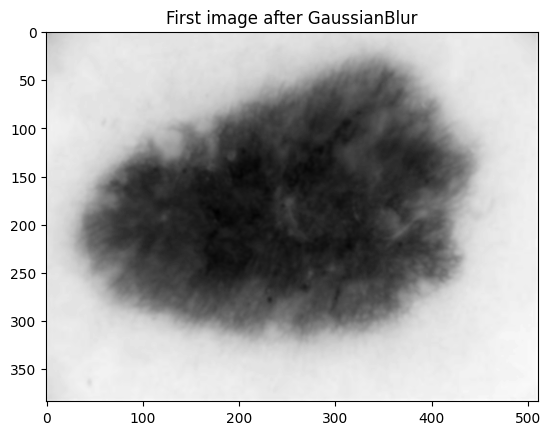

In [21]:
# Display the first image
plt.imshow(train_images[0][3], cmap='gray')
plt.title('First image after GaussianBlur')
plt.show()

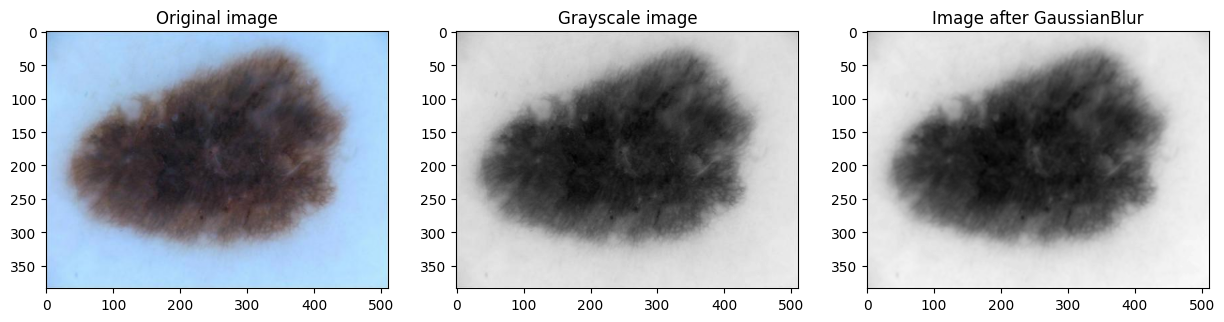

In [22]:
#Plot the three images in a row
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

#Plot the original image
ax[0].imshow(train_images[0][1], cmap='gray')
ax[0].set_title('Original image')

#Plot the grayscale image
ax[1].imshow(train_images[0][2], cmap='gray')
ax[1].set_title('Grayscale image')

#Plot the image after GaussianBlur
ax[2].imshow(train_images[0][3], cmap='gray')
ax[2].set_title('Image after GaussianBlur')

plt.show()

## Segmentation

In [23]:
def get_chan_vese(image):
    return chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

def get_segmentation(image):
    return [image[0], image[1], image[2], image[3], get_chan_vese(image[3])[0]]

def joblib_segmentation(images):
    return Parallel(n_jobs=-2, verbose=1)(delayed(get_segmentation)(image) for image in images)

#Apply the Chan-Vese segmentation to the images
train_images = joblib_segmentation(train_images)
test_images = joblib_segmentation(test_images)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed:  5.4min


KeyboardInterrupt: 

In [ ]:
#plot the original image, the gray, the blur and the segmentation
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(train_images[0][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[0][2], cmap='gray')
ax[1].set_title('Grayscale image')

ax[2].imshow(train_images[0][3], cmap='gray')
ax[2].set_title('GaussianBlur image')

ax[3].imshow(train_images[0][4], cmap='gray')
ax[3].set_title('Segmentation image')

plt.show()

NameError: name 'plt' is not defined

## Image Postprocessing

In [ ]:
#morphological operations
def get_morphological_operations(image):
    # Convert the image to the appropriate data type
    image = image.astype(np.uint8)

    # Morphological opening
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    # Morphological closing
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    return closing

train_images =  [[image[0], image[1], image[2], image[3], image[4], get_morphological_operations(image[4])] for image in train_images]
test_images =   [[image[0], image[1], image[2], image[3], image[4], get_morphological_operations(image[4])] for image in test_images]

IndexError: list index out of range

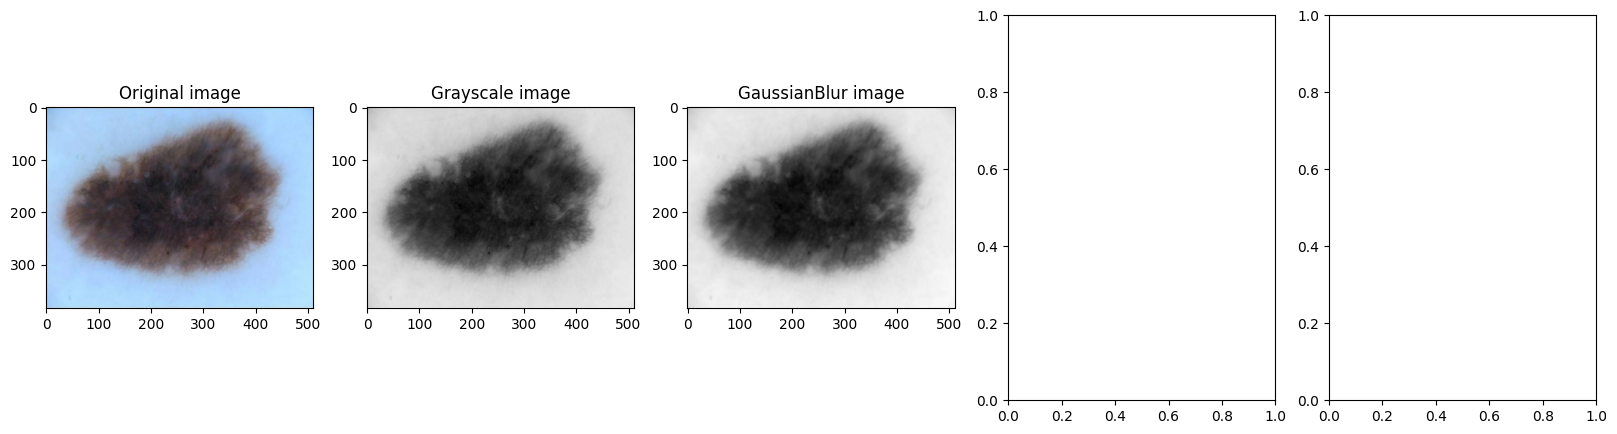

In [ ]:
#plot the original image, the gray, the blur and the segmentation
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].imshow(train_images[0][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[0][2], cmap='gray')
ax[1].set_title('Grayscale image')

ax[2].imshow(train_images[0][3], cmap='gray')
ax[2].set_title('GaussianBlur image')

ax[3].imshow(train_images[0][4], cmap='gray')
ax[3].set_title('Segmentation image')

ax[4].imshow(train_images[0][5], cmap='gray')
ax[4].set_title('Morphological operations')

plt.show()

In [ ]:
#comparison of the original masks and the segmented ones
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

#get the first 5 masks
first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0

for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    #Get the mask
    mask = next((item for item in train_masks if item[0] == i), None)
    
    #Get the class
    class_ = train_data[train_data['ID'] == i]['CLASS'].values[0]
    
    #Plot the original mask
    ax[j, 0].imshow(mask[1])
    ax[j, 0].set_title(f'Original Mask {mask[0]} - Class {class_}')
    
    #Plot the segmented mask
    ax[j, 1].imshow(image[5])
    ax[j, 1].set_title(f'Segmented Mask {image[0]} - Class {class_}')

    j += 1

plt.show()

In [ ]:
#Dice score between the original masks and the segmented ones
def dice_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return 2 * intersection.sum() / (mask1.sum() + mask2.sum())

dice_scores = []

for mask in train_masks:
    #The image in the original mask
    mask_original = mask[1]
    #The segmented mask
    mask_segmented = next((item for item in train_images if item[0] == mask[0]), None)

    dice_scores.append(dice_score(mask_original, mask_segmented[5]))

for mask in test_masks:
    #The image in the original mask
    mask_original = mask[1]
    #The segmented mask
    mask_segmented = next((item for item in test_images if item[0] == mask[0]), None)

    dice_scores.append(dice_score(mask_original, mask_segmented[5]))

In [ ]:
#Plot the dice scores
plt.hist(dice_scores, bins=20)
plt.title('Dice scores')
plt.show()

## Border Detection

In [ ]:
#Find contours in the segmented masks
def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

train_images =  [[image[0], image[1], image[2], image[3], image[4], image[5], get_contours(image[5])] for image in train_images]
test_images =   [[image[0], image[1], image[2], image[3], image[4], image[5], get_contours(image[5])] for image in test_images]

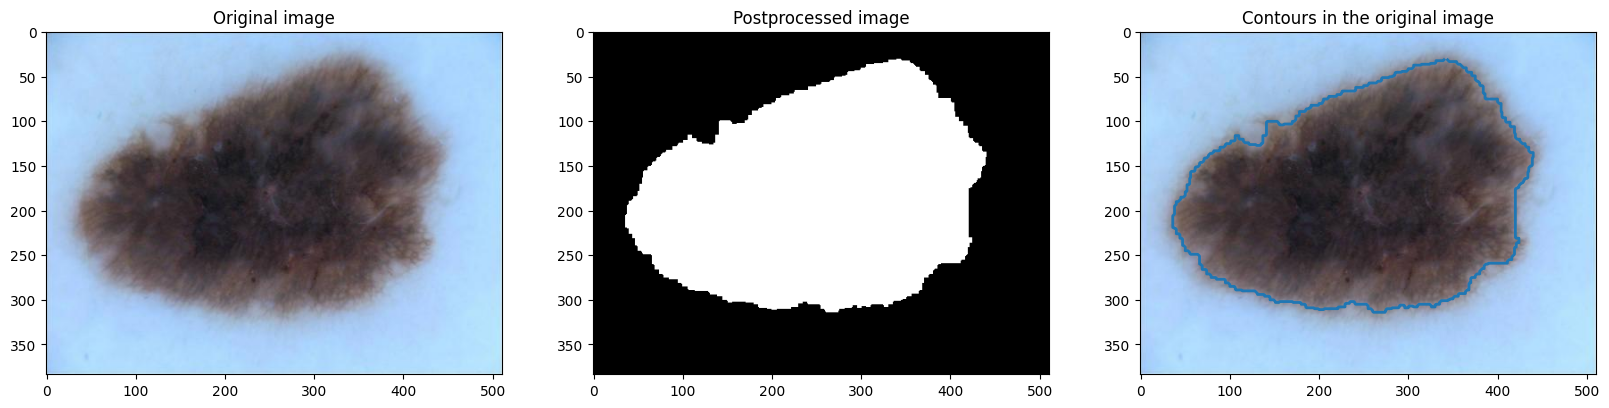

In [ ]:
#Plot the original ilage, the postprocessed, and the contours in the original one
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].imshow(train_images[0][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[0][5], cmap='gray')
ax[1].set_title('Postprocessed image')

ax[2].imshow(train_images[0][1])
ax[2].set_title('Contours in the original image')
for contour in train_images[0][6]:
    ax[2].plot(contour[:, 0, 0], contour[:, 0, 1], linewidth=2)

plt.show()

## Feature Extraction

The ABCD rule is a method to evaluate the risk of a skin lesion being a melanoma. It is based on the following features:
- **A**symmetry
- **B**order irregularity
- **C**olour
- **D**imension

In [ ]:
train_images_features = []
test_images_features = []

### Asymmetry




In [ ]:
# Function to calculate the distance between two points
def distance(p1, p2):
    return np.sqrt((p1[0][0] - p2[0][0])**2 + (p1[0][1] - p2[0][1])**2)

def longest_diagonal(lesion_boundary):

    # Initialize the maximum diagonal length and coordinates
    max_diag_length = 0
    max_diag_coords = (0, 0, 0, 0)

    # Find the longest diagonal by checking distances between all pairs of points
    for i in range(len(lesion_boundary)):
        for j in range(i+1, len(lesion_boundary)):
            diag_length = distance(lesion_boundary[i], lesion_boundary[j])
            if diag_length > max_diag_length:
                max_diag_length = diag_length
                max_diag_coords = lesion_boundary[i], lesion_boundary[j]

    return max_diag_coords

def calculate_assymetry_features(image):
    # Assuming the largest contour corresponds to the lesion boundary
    # This will be a list of (row, col) coordinates of the boundary pixels
    lesion_boundary = max(image[6], key=len)

    # Find the longest diagonal of the lesion
    max_diag_coords = longest_diagonal(lesion_boundary)
    
    # Define the number of perpendicular lines
    N = 10
    T = len(lesion_boundary)
    P = T / N
    
    # Calculate the distances from points on the diagonal to the lesion boundary
    diagonal_length = np.linalg.norm(max_diag_coords[0] - max_diag_coords[1])
    step_size = diagonal_length / N
    distances = []
    for i in range(N):
        point_on_diagonal = max_diag_coords[0] + (max_diag_coords[1] - max_diag_coords[0]) * (i * step_size / diagonal_length)
        perp_distances = [np.linalg.norm(point_on_diagonal - contour_point) for contour_point in lesion_boundary]
        distances.append((min(perp_distances), max(perp_distances)))
    
    # Compute the features
    ratios = [d[0] / d[1] if d[1] != 0 else 0 for d in distances]
    std_dev = np.std(ratios)
    
    # Return the features
    return ratios + [std_dev]


### Border Irregularity

In [ ]:
def calculate_border_irregularity_features(border):
    """
    Calculate border irregularity features based on the inflection points and vector product descriptors.
    
    :param border: A numpy array of the contour points of the lesion border.
    :return: A dictionary with counts of peaks, valleys, and straight lines for both small and large irregularities.
    """
    border = border[:, 0, :]
        
    # Initialize the counts for small irregularities
    small_irregularities = {'peaks': 0, 'valleys': 0, 'straight_lines': 0}

    # Initialize the counts for large irregularities
    large_irregularities = {'peaks': 0, 'valleys': 0, 'straight_lines': 0}

    # Inflection point descriptor parameters
    T1 = 2
    T2 = -2

    # Calculate small irregularities based on inflection points
    for i in range(1, len(border) - 1):
        # Get the neighbors
        left_neighbor = border[i - 1]
        right_neighbor = border[i + 1]

        # Calculate the weights (y-axis difference)
        Wl = left_neighbor[1] - border[i][1]
        Wr = right_neighbor[1] - border[i][1]

        # Sum the weights
        S = Wl + Wr

        # Determine if it's a peak, valley, or straight line based on the weight sum
        if S > T1:
            small_irregularities['peaks'] += 1
        elif S < T2:
            small_irregularities['valleys'] += 1
        else:
            small_irregularities['straight_lines'] += 1

    # Function to calculate vector product V for three points p1, p2, p3
    def vector_product(p1, p2, p3):
        (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
        return (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)

    # Calculate large irregularities based on vector products
    for i in range(len(border)):
        # Ensure circular indexing at the borders
        p1 = border[i - 15 if i >= 15 else i - 15 + len(border)]
        p2 = border[i]
        p3 = border[(i + 15) % len(border)]

        # Calculate the vector product
        V = vector_product(p1, p2, p3)

        # Determine if it's a peak, valley, or straight line based on vector product
        if V > 0:
            large_irregularities['peaks'] += 1
        elif V < 0:
            large_irregularities['valleys'] += 1
        else:
            large_irregularities['straight_lines'] += 1

    # Return the calculated features
    return small_irregularities, large_irregularities


### Colour

In [ ]:
def calculate_color_features(image):
    """
    Calculate color features for an image in the RGB color space.
    
    :param image: RGB image as a numpy array.
    :return: A dictionary with the mean, variance, and standard deviation for each RGB channel.
    """
    color_features = {}
    # Split the image into R, G, and B channels
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    # Calculate the mean, variance, and standard deviation for each channel
    color_features['mean_R'] = np.mean(R)
    color_features['mean_G'] = np.mean(G)
    color_features['mean_B'] = np.mean(B)
    
    color_features['variance_R'] = np.var(R)
    color_features['variance_G'] = np.var(G)
    color_features['variance_B'] = np.var(B)
    
    color_features['std_dev_R'] = np.std(R)
    color_features['std_dev_G'] = np.std(G)
    color_features['std_dev_B'] = np.std(B)
    
    return color_features

### Dimension

In [ ]:
def calculate_fractal_dimension(image):
    """
    Calculate the fractal dimension of an image using the box-counting method.
    
    :param image: Mask image as a numpy array.
    :return: The fractal dimension D of the image.
    """

    # Box-counting implementation
    def boxcount(binary_image, k):

        S = np.add.reduceat(
                np.add.reduceat(binary_image, 
                                np.arange(0, binary_image.shape[0], k), axis=0),
                np.arange(0, binary_image.shape[1], k), axis=1)
        
        return len(np.where(S > 0)[0])

    # Fractal dimension calculation
    p = min(image.shape)
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))
    sizes = 2**np.arange(n, 1, -1)
    counts = []
    for size in sizes:
        counts.append(boxcount(image, size))

    if len(sizes) > 0 and len(counts) > 0:
        coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    else:
        coeffs = np.array([0, 0])

    return -coeffs[0] if len(coeffs) > 0 else 0


In [ ]:
def calculate_texture_features(image):
    """
    Calculate the texture features of an image.
    
    :param image_path: mask image.
    :return: A dictionary with the calculated texture features.
    """
    
    # Calculate the fractal dimension of the whole image
    D = calculate_fractal_dimension(image)

    # Calculate the fractal dimension of 16 parts of the image
    rows, cols = image.shape
    step_r, step_c = rows // 4, cols // 4
    D_parts = []
    for i in range(0, rows, step_r):
        for j in range(0, cols, step_c):
            part = image[i:i+step_r, j:j+step_c]
            
            D_parts.append(calculate_fractal_dimension(part))
    
    # Calculate the image-based fractal dimension D2
    D2 = np.mean(D_parts) + 1
    
    # Create a dictionary to store the texture features
    texture_features = {
        'fractal_dimension_total': D,
        'fractal_dimensions_parts': D_parts,
        'fractal_dimension_D2': D2
    }
    
    return texture_features

### Add features

In [ ]:
def get_features(image):
    return [
        image[0], 
        calculate_assymetry_features(image), 
        calculate_border_irregularity_features(image[6]), 
        calculate_color_features(image[1]), 
        calculate_texture_features(image[5])
    ] 

def joblib_features(images):
    return Parallel(n_jobs=-2, verbose=1)(delayed(get_features)(image) for image in images)

train_images_features = joblib_features(train_images)
test_images_features = joblib_features(test_images)

# Final Dataset

In [ ]:
# Create a DataFrame with the calculated features and the features from the metadata
train_features_df = pd.DataFrame(train_images_features, columns=['ID', 'asymmetry', 'border_irregularity', 'color', 'texture'])
test_features_df = pd.DataFrame(test_images_features, columns=['ID', 'asymmetry', 'border_irregularity', 'color', 'texture'])

# Merge the metadata with the calculated features
train_data = train_data.merge(train_features_df, on='ID')
test_data = test_data.merge(test_features_df, on='ID')

# Classification

### Preprocessing Data

In [ ]:
#One hot encoding SEX and POSITION
train_data = pd.get_dummies(train_data, columns=['SEX','POSITION'])
test_data = pd.get_dummies(test_data, columns=['SEX','POSITION'])

#Drop the ID column
train_data = train_data.drop(columns='ID')
test_data = test_data.drop(columns='ID')

#Split the data
X_train = train_data.drop(columns='CLASS')
y_train = train_data['CLASS']

X_test = test_data

#Normalize and scale data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.describe()

In [ ]:
#SVM

#Grid search
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_estimator_)

#Predictions
grid_predictions = grid.predict(X_test)



In [ ]:
#Random Forest

#Grid search
param_grid = {'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2']}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_estimator_)

#Predictions
grid_predictions = grid.predict(X_test)


In [ ]:
#Logistic Regression

#Grid search
param_grid = {'C': [0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_estimator_)

#Predictions
grid_predictions = grid.predict(X_test)

In [ ]:
#KNN

#Grid search
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_estimator_)

#Predictions
grid_predictions = grid.predict(X_test)

In [ ]:
# Tensorflow Neural Network

#Create the model
model = Sequential()
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
model.fit(X_train, y_train, epochs=150, batch_size=10)

#Predictions
y_pred = model.predict(X_test)

# Metrics
As ranking metric, we will use the Weighted Categorization Accuracy which is defined as:
$$WA=1N∑i=1NwiI(yi=fi)$$
such that
$$∑i=1Nwi=N$$
in order to keep the maximum value equal to 1

where $y_i$ are ground truths, $f_i$ are the predicted results, and $w_i$ are the weights of the $i-th$ test image. If we make the hypothesis that we have $K$ groups - or classes - called $G={G_1,…,G_K}$ and we associate the same weight $w_t$ to all images of the same group $t$, we obtain that the weights are equal to: $w_t = \frac{ N }{ k |G_t|}$

In this way, we can take into account the imbalance nature of the data-set, if present.
Please note that the class weights in the test set are equal to: [ 0.7005531 0.24592265 0.95261733 3.64804147 1.20674543 13.19375 12.56547619 5.04219745]

# Conclusions

# References


* http://ieeexplore.ieee.org/document/918473/
* https://www.sciencedirect.com/science/article/pii/S0933365712001108#bib0180
* https://www.sciencedirect.com/science/article/pii/S0957417416302354#bib0023
* https://www.sciencedirect.com/science/article/pii/S0933365713001589
* https://www.nature.com/articles/nature21056
* https://hal-univ-bourgogne.archives-ouvertes.fr/hal-01250955/document
* https://workshop2021.isic-archive.com/
* https://workshop2020.isic-archive.com/#paper